<a href="https://colab.research.google.com/github/hizieun/ToTheTransformer/blob/main/_04_multiclass_classification_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 설치

In [ ]:
%%capture
!pip install gdown

라이브러리 import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/23.09.19-22_트랜스포머교육/code')
from multiclass_functions1 import * # * 은 all을 의미
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


하이퍼파라미터 및 모델 불러오기

In [ ]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss() # 클래스. 주로 이렇게 사용함!

model_type = "CNN_deep"
# model_type = "CNN"
# model_type = "MLP"
dataset = "CIFAR10"

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로
if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1cmT9sv8KM2KYJQQXjT-WUy3cj0s-VcG1 -O MLP_CIFAR10.pt
    !gdown https://drive.google.com/uc?id=1tLYAVxpByFbHKjM0FCHCp3n9Uz5TRVVJ -O CNN_CIFAR10.pt
    !gdown https://drive.google.com/uc?id=1LGWvbr0xanYi4xCyriiT7tGVaPaFIPOW -O CNN_deep_CIFAR10.pt
    save_model_path = f'{model_type}_{dataset}.pt'
    save_history_path = f'{model_type}_history_{dataset}.pt'
else:
    save_model_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt'
    save_history_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt'

Downloading...
From: https://drive.google.com/uc?id=1cmT9sv8KM2KYJQQXjT-WUy3cj0s-VcG1
To: /content/MLP_CIFAR10.pt
100% 375k/375k [00:00<00:00, 98.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tLYAVxpByFbHKjM0FCHCp3n9Uz5TRVVJ
To: /content/CNN_CIFAR10.pt
100% 56.1k/56.1k [00:00<00:00, 90.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LGWvbr0xanYi4xCyriiT7tGVaPaFIPOW
To: /content/CNN_deep_CIFAR10.pt
100% 6.14M/6.14M [00:00<00:00, 64.2MB/s]


데이터 불러오기

In [ ]:
transform = transforms.ToTensor() # 텐서로 변환
train_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform)
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True) # DataLoader=데이터가 담긴 주머니
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_DS)
print(test_DS)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Test
    StandardTransform
Transform: ToTensor()


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.Size([32, 3, 32, 32])
frog


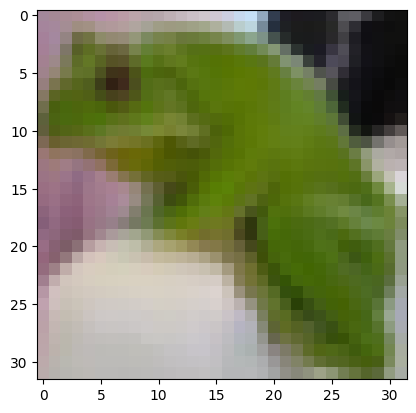

In [ ]:
print(test_DS.classes)
print(test_DS.class_to_idx)
x_batch, y_batch = next(iter(test_DL))  # x=입력,y=출력
print(x_batch.shape)                    # 개채행렬(32개의 이미지, 컬러형태의 32*32 해상도)
plt.imshow(x_batch[0].permute(1,2,0))   # 개행렬채 형태로 바꿔줌
print(test_DS.classes[y_batch[0]])
# y_batch[0]

In [ ]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 국자 # next(iter(train_DS)) 는 한장만 꺼내기
# ToTensor 의 역할
# 1. tensor 로 바꾸고
# 2. 개채행열로 바꾸고
# 3. 0~1 사이로 바꾸고 (int -> float)
print(type(train_DS.data))
print(train_DS.data.shape)
print(train_DS.data.dtype)
print(train_DS.data[0][0][0][0])

print(type(x_batch))
print(x_batch.shape)
print(x_batch.dtype)
print(x_batch[0][0][0][0])

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
uint8
59
<class 'torch.Tensor'>
torch.Size([32, 3, 32, 32])
torch.float32
tensor(0.1765)


In [ ]:
# x_batch.shape                             # torch.Size([32, 3, 32, 32])
# model = nn.Linear(32,3*32*32)
# model(x_batch)
# 3*32*32를 직접 계산하지 않고 flatten 함수로 대체해서 사용!
torch.flatten(x_batch,start_dim=1).shape    # torch.Size([32, 3072])

torch.Size([32, 3072])

In [ ]:
bn = nn.BatchNorm1d(30)
bn.weight
# tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
#         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
# bn.bias
# tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0.], requires_grad=True)
# 평균 0, 분산1로 시작해서 배치놈으로 재배치를 진행하겠다.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(nn.Linear(3*32*32, 30), # 왜 3*32*32일까? x_batch에서 채행렬 자체를 노드값으로 넣어주기 위해
                                 nn.BatchNorm1d(30),
                                 nn.ReLU(),
                                 nn.Linear(30, 10)) # 10 = 클래스수
    def forward(self,x):
        x = torch.flatten(x, start_dim=1)  # torch.Size([32, 3072]) 모든 픽셀을 노드로 봐야하기 때문에 쭉 펴주는게 필요!
        x = self.fcs(x)
        return x

# CNN_deep이 성능이 더 좋음
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3,8,3, padding=1),
                                   nn.BatchNorm2d(8),
                                   nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Maxpool1(x)
        x = self.conv2(x)
        x = self.Maxpool2(x)
        x = self.conv3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                        nn.ReLU(),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model = eval(f"{model_type}().to(DEVICE)")
# model = MLP().to(DEVICE) # 위와 똑같은 코드
# to.(DEVICE) : GPU에 올려서 연산처리
# x, y, model 모두 DEVICE에 올려줘야함
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape) # torch.Size([32, 10])

# print(count_params(model))

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr = LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.figure()
    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid()

In [ ]:
load_model = torch.load(save_model_path, map_location=DEVICE)

테스트

In [ ]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 7994/10000 (79.9 %)
1527018


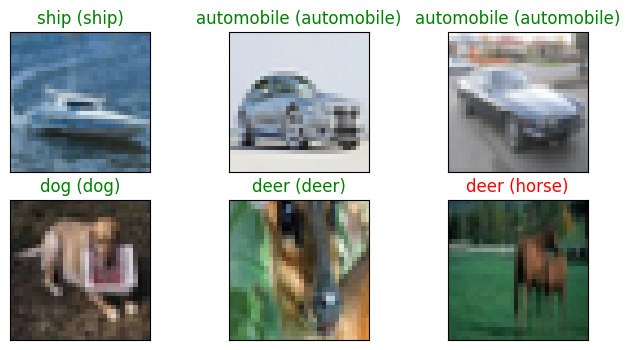

In [ ]:
Test_plot(load_model,test_DL) # 결과 : "예측값(실제정답값)"